In [1]:
import os
import glob
import numpy as np
import pandas as pd

from scipy.spatial.distance import pdist, squareform

import matplotlib.pyplot as plt
import seaborn as sns

import nibabel as nib


from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from sklearn.model_selection import cross_val_predict, StratifiedKFold, cross_val_score, permutation_test_score
from sklearn.metrics import mean_squared_error, accuracy_score, confusion_matrix, classification_report, pairwise_distances
from imblearn.over_sampling import SMOTE 

%matplotlib inline

In [3]:
 
def make_TR(input_list):
    return [round(x/2) for x in input_list]
    
def clean_time_point(input_list):
    
    output_list = []
    
    # remove out of bounds
    bounds = [15, 1493-15]
    output_list = [item for item in input_list if bounds[0] <= item <= bounds[1]]

    # remove each run end
    for TR_i in [ 250, 549, 742, 946, 1232, 1493]:
        output_list = [item for item in output_list if ( TR_i+15 <= item) or( item <= TR_i-15)]

    return output_list
def to_square(data):
    n = len(data)
    size = int(np.ceil(np.sqrt(n)))  
    padded_size = size**2  
    # 将数据填充到一个大小为 size x size 的矩阵中
    padded_data = np.full((padded_size,), np.nan)  # 使用 NaN 进行填充
    padded_data[:n] = data  # 仅将原始数据填入前面部分
    matrix = padded_data.reshape((size, size))
    return  matrix

def extract_values_around_time_points(array, time_points):
    
    num_features, num_time_points = array.shape
    extracted_values = []
    for point in time_points:
        # 找到时间点在数组中的索引
        idx = point
        # 提取时间点后的第2到第5个时间点的值
        start_idx = idx + 2
        end_idx = idx + 4
        
        if end_idx < num_time_points:
            values = array[:,start_idx:end_idx]  # 提取第2到第5个时间点的所有特征
        else:
            values = array[:,start_idx:]  # 如果超出数据范围，就取到末尾
        
        # 计算这些值的平均值
        if values.size > 0:
            avg_value = np.mean(values, axis=1)  # 计算每个特征的平均值
        else:
            avg_value = np.full(num_features, np.nan)  # 如果没有值，返回NaN

        extracted_values.append(avg_value)

    return np.array(extracted_values)


In [5]:
roi_name = '7Networks_LH_Default_PFC_8'
sub_list = list(range(13, 51))
run_list = [1,2,3,4,5,6]
sub_list.remove(21)


results = []
for sub in sub_list:
    
    # change time point（秒）
    sub_time_file = f'/Users/li/Desktop/debate/behavedata/during_scan/combined_6runs_filter_diff/subject_{sub}_rate_diff.csv'
    sub_time = pd.read_csv(sub_time_file)

    change_time = list(sub_time['time'][1:])
    change_time = make_TR(change_time)
    change_time = clean_time_point(change_time)
    
    pre_rate = list(sub_time['rate'][:-1])
    change = list(sub_time['rate_diff'][1:])

    # brain date
    brain_data = []  
    for run in run_list:
        pattern_file = f'/Users/li/Desktop/debate/braindata/denoised 6/ROI Spatial Pattern/7Networks_LH_Default_PFC_8/sub-0{sub}/sub-0{sub}_run-{run}_7Networks_LH_Default_PFC_8_voxel_time_series.npy'
        run_data = np.load(pattern_file) 
        brain_data.append(run_data) 
    brain_data = np.concatenate(brain_data, axis=1)

    
    pattern = extract_values_around_time_points(brain_data, change_time)

    # pattern.shape = (11, 644)
    # len(change_time) = 11
    for i in range(len(change_time)):
        
        row_data = {'subject': sub, 'change_time': change_time[i], 'pre_rate': pre_rate[i], 'change': change[i],'type':None}

        voxel_data = pattern[i]
        for j, voxel_value in enumerate(voxel_data):
            row_data[f'voxel_{j+1}'] = voxel_value
        
        results.append(row_data)
        
df = pd.DataFrame(results)
df


,subject,change_time,pre_rate,change,type,voxel_1,voxel_2,voxel_3,voxel_4,voxel_5,...,voxel_635,voxel_636,voxel_637,voxel_638,voxel_639,voxel_640,voxel_641,voxel_642,voxel_643,voxel_644
0,13,205,12,1.0,None,0.729764,0.465377,0.840025,0.699739,0.413421,...,-0.202596,0.233289,0.399591,0.448537,0.354444,0.265069,-0.147897,-0.057743,0.232851,0.104051
1,13,330,13,1.0,None,0.183573,0.018991,0.265141,0.223465,-0.112265,...,-0.427251,-0.154373,-0.236164,-0.402795,-0.500138,-0.481635,-0.344363,-0.326626,-0.626801,-0.688221
2,13,381,14,-1.0,None,-0.340399,-0.242953,-1.014434,-0.830840,-0.279000,...,0.338999,0.788347,0.774060,0.686413,0.524180,0.625642,-0.036645,0.026975,0.308806,0.276967
3,13,590,13,1.0,None,-0.802499,-0.607875,-0.582157,-0.227087,0.128458,...,-0.831180,-0.398804,-0.298041,-0.299187,-0.317628,-0.363827,-0.367158,-0.328993,-0.425133,-0.463900
4,13,603,14,-1.0,None,-0.139120,0.095990,-0.644857,-0.512455,-0.150506,...,1.371732,1.373477,1.508156,1.597900,1.444858,1.210923,1.011036,1.019573,1.318806,1.097110
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
597,50,704,10,-2.0,None,-0.735566,-0.590275,-0.856206,-0.664709,0.066867,...,0.772495,0.284396,-0.033531,-0.186382,-0.172289,-0.232946,0.568179,0.299467,-0.400579,-0.352309
598,50,724,8,-1.0,None,0.331169,0.255489,0.242808,0.069959,-0.330289,...,-0.364592,0.091612,-0.104118,-0.483140,-0.809075,-1.122652,-0.244531,-0.242914,-1.058802,-1.456579
599,50,905,7,-1.0,None,0.401654,0.084910,0.248851,-0.257564,-0.670499,...,1.261692,1.406624,1.507265,1.490141,1.348949,1.010638,1.801027,1.913936,1.182856,0.949819
600,50,1084,6,-1.0,None,-1.701737,-1.320654,-0.876732,-0.786147,-0.729415,...,0.322872,0.060469,-0.117371,-0.172154,-0.144844,-0.233380,0.183646,0.145952,-0.194665,-0.407598


(543, 649)
置换检验得分: 0.27
置换检验的p值: 0.3676
混淆矩阵:
[[53 45 60 44]
 [65 60 34 29]
 [26 17 13 14]
 [28 17 17 21]]
分类报告:
              precision    recall  f1-score   support

         1.0       0.31      0.26      0.28       202
         2.0       0.43      0.32      0.37       188
         3.0       0.10      0.19      0.13        70
         4.0       0.19      0.25      0.22        83

    accuracy                           0.27       543
   macro avg       0.26      0.26      0.25       543
weighted avg       0.31      0.27      0.28       543



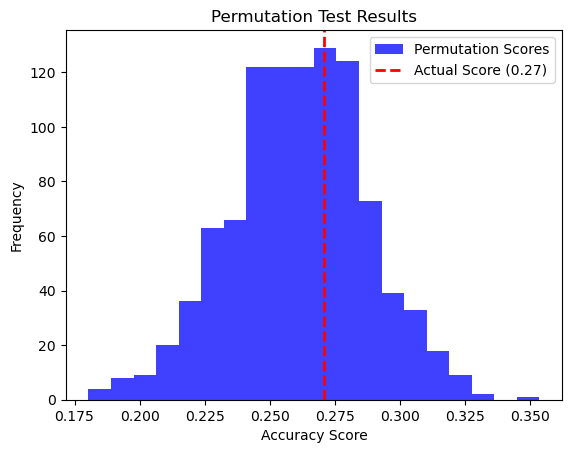

In [7]:
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC
from sklearn.model_selection import permutation_test_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt

# 复制原始数据
df_expanded = df.copy()

# 定义类型
def set_type(row):
    if row['pre_rate'] > 7 and row['change'] > 0:
        return 1
    elif row['pre_rate'] > 7 and row['change'] < 0:
        return 2
    elif row['pre_rate'] < 7 and row['change'] < 0:
        return 3
    elif row['pre_rate'] < 7 and row['change'] > 0:
        return 4
    else:
        return None  

# 应用类型
df_expanded['type'] = df_expanded.apply(set_type, axis=1)
df_expanded = df_expanded.dropna(subset=['type'])

# 打印数据集大小
print(df_expanded.shape)

# 定义特征和目标
X = df_expanded.drop(columns=['subject', 'change_time', 'pre_rate', 'change', 'type'])  # 特征
y = df_expanded['type']  # 目标

# 使用PCA降维
pca = PCA(n_components=0.95)  # 保留95%的方差
X_pca = pca.fit_transform(X)

# 设置交叉验证
kfold = StratifiedKFold(n_splits=8, shuffle=True, random_state=42)
from sklearn.model_selection import LeaveOneOut
loo = LeaveOneOut()

# 定义SVM模型
svm_model = SVC(class_weight='balanced')

# 进行置换检验
score, permutation_scores, pvalue = permutation_test_score(
    svm_model, X_pca, y, cv=kfold, n_permutations=1000, n_jobs=-1, scoring="accuracy", random_state=42)

# 输出置换检验得分和p值
print(f"置换检验得分: {score:.2f}")
print(f"置换检验的p值: {pvalue:.4f}")

# 使用交叉验证进行预测
y_pred = cross_val_predict(svm_model, X_pca, y, cv=loo)

# 计算混淆矩阵
conf_matrix = confusion_matrix(y, y_pred)

# 输出混淆矩阵
print("混淆矩阵:")
print(conf_matrix)

# 输出分类报告
print("分类报告:")
print(classification_report(y, y_pred))

# 可视化置换检验结果
plt.hist(permutation_scores, bins=20, alpha=0.75, color='blue', label='Permutation Scores')
plt.axvline(score, color='red', linestyle='--', linewidth=2, label=f'Actual Score ({score:.2f})')
plt.xla
bel('Accuracy Score')
plt.ylabel('Frequency')
plt.title('Permutation Test Results')
plt.legend(loc='best')
plt.show()


In [10]:
accuracy = accuracy_score(y, y_pred)
print(f"loo 正确率: {accuracy:.2f}")

loo 正确率: 0.27


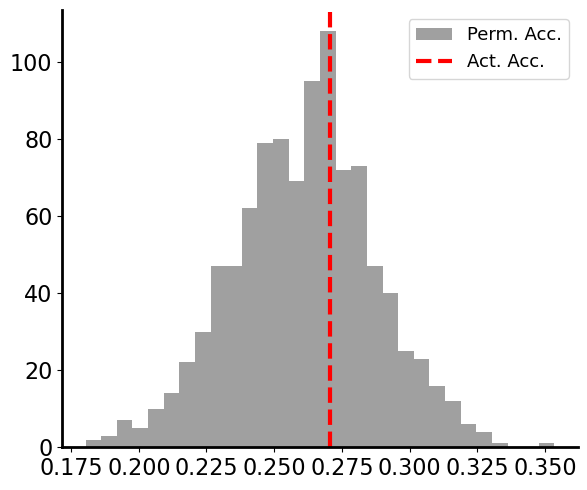

In [14]:

plt.figure(figsize=(6, 5))
# 可视化置换检验结果
plt.hist(permutation_scores, bins=30, alpha=0.75, color='grey', label='Perm. Acc.')
plt.axvline(accuracy, color='red', linestyle='--', linewidth=3, label='Act. Acc.')
plt.xticks(fontsize=16)  # 设置 x 轴刻度字体大小
plt.yticks(fontsize=16)  # 设置 y 轴刻度字体大小

# 去掉上面和左边的框线
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# 设置 y 轴坐标从 0.05 开始
# plt.ylim(bottom=0.05)

# 加粗左边和下边的轴线
plt.gca().spines['left'].set_linewidth(2)
plt.gca().spines['bottom'].set_linewidth(2)

plt.legend(loc='best', fontsize=13)

plt.tight_layout()
# 保存图像
plt.savefig('/Users/li/Desktop/Figure/6d1.png', dpi=300)
# plt.xlabel('Accuracy Score')
# plt.ylabel('Frequency')
# plt.title('Permutation Test Results')

plt.show()

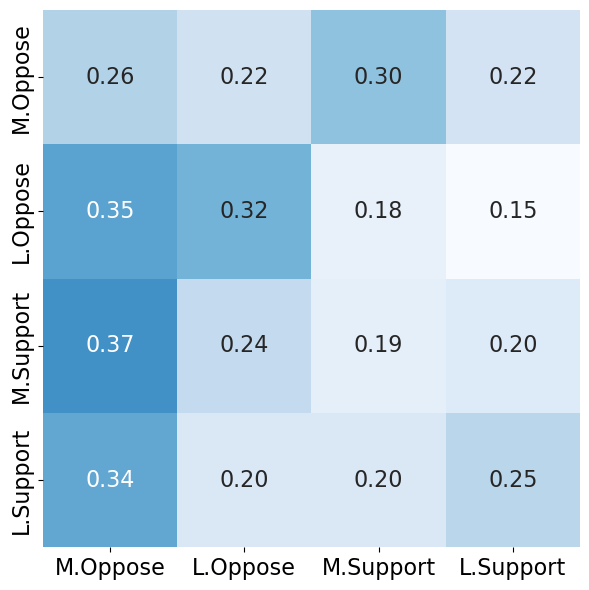

In [16]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# 原始混淆矩阵
conf_matrix = np.array(
[[53,45,60,44],
 [65,60,34,29],
 [26,17,13,14],
 [28,17,17,21]]
)

# 计算每一行的总和
row_sums = conf_matrix.sum(axis=1, keepdims=True)

# 计算百分比（每个元素除以其所在行总和）
percent_matrix = conf_matrix / row_sums

# 设置图形
plt.figure(figsize=(6, 6))
ax = sns.heatmap(percent_matrix, annot=True, fmt=".2f", cmap="Blues", cbar=False, square=True, vmax = 0.5,annot_kws={"size": 16},
                 xticklabels=["M.Oppose", "L.Oppose", "M.Support", "L.Support"],
                 yticklabels=["M.Oppose", "L.Oppose", "M.Support", "L.Support"])

# 标题和标签
# plt.title("Confusion Matrix (Row-Normalized as Percentages)", fontsize=14)
# plt.xlabel("Predicted Label")
# plt.ylabel("True Label")

plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
plt.tight_layout()
plt.savefig('/Users/li/Desktop/Figure/6c1.png', dpi=300)
plt.show()
